# **Plotting the theoretical $w(\theta)$ for a given cosmology and a set of redshift distributions**

This notebook plots the theoretical angular correlation function $w(\theta)$ based on a given cosmology and redshift distributions.


In [1]:
%load_ext autoreload
%autoreload 2

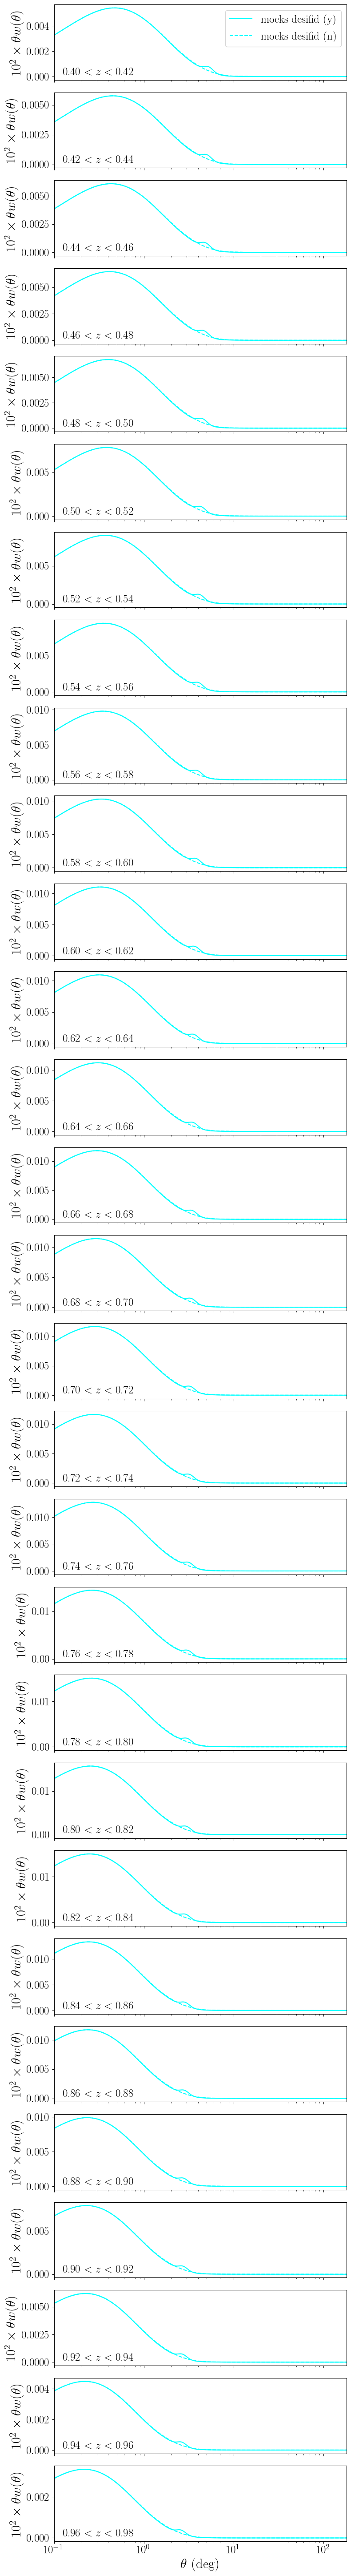

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
from utils_template import TemplateInitializer
from utils_data import RedshiftDistributions

galaxy_bias = {bin_z: 1.5 for bin_z in range(30)}

# nz_flags = ["fid"]
# cosmology_templates = ["mice", "planck"]

# nz_flags = ["fid", "clusteringz"]
# cosmology_templates = ["planck"]

# nz_flags = ["fid"]
# cosmology_templates = ["planck"]

# dataset = "DESY6"
# nz_flags = ["fid"]
# cosmology_templates = ["mice"]

# dataset = "DESY6_COLA"
# nz_flags = ["mocks"]
# cosmology_templates = ["mice"]

dataset = "DESIY1_LRG_Abacus"
nz_flags = ["mocks"]
cosmology_templates = ["desifid"]

colors = {
    ("DESY6", "fid", "mice"): "blue", 
    ("DESY6", "fid", "planck"): "red", 
    ("DESY6", "fid", "desifid"): "purple",
    ("DESY6", "clusteringz", "mice"): "green", 
    ("DESY6", "clusteringz", "planck"): "orange",
    ("DESY6_COLA", "mocks", "mice"): "brown", 
    ("DESIY1_LRG_Abacus", "mocks", "desifid"): "cyan", 
}

nbins = {
    ("DESY6", "fid"): 6,
    ("DESY6","clusteringz"): 4,
    ("DESY6_COLA", "mocks"): 6,
    ("DESIY1_LRG_Abacus", "mocks"): 29,
}

linestyle = {"y": "-", "n": "--"}

nbins_max = max(nbins[dataset, nz_flag] for nz_flag in nz_flags)
text_added = {bin_z: False for bin_z in range(nbins_max)}

fig, axs = plt.subplots(nbins_max, 1, figsize=(8, 2 * nbins_max), sharex=True)

for cosmology_template in cosmology_templates:
    for nz_flag in nz_flags:
        z_edges = RedshiftDistributions(dataset, nz_flag, verbose=False).z_edges
        color = colors[(dataset, nz_flag, cosmology_template)]
        
        wtheta = {}
        wtheta_bb = {}
        wtheta_bf = {}
        wtheta_ff = {}

        for bin_z in range(nbins[dataset, nz_flag]):
            ax = axs[bin_z]
            
            for include_wiggles in ["y", "n"]:
                
                label = nz_flag + " " + cosmology_template + " (" + include_wiggles + ")"
                
                template_initializer = TemplateInitializer(
                    include_wiggles="" if include_wiggles == "y" else "_nowiggles",
                    dataset=dataset,
                    nz_flag=nz_flag,
                    cosmology_template=cosmology_template,
                    verbose=False,
                    base_path=None,
                )
                wtheta_dict = template_initializer.load_wtheta(bin_z)
                
                theta = wtheta_dict["bb"][:, 0]
                wtheta_bb[bin_z] = wtheta_dict["bb"][:, 1]
                wtheta_bf[bin_z] = wtheta_dict["bf"][:, 1]
                wtheta_ff[bin_z] = wtheta_dict["ff"][:, 1]
                
                wtheta[bin_z] = galaxy_bias[bin_z] ** 2 * wtheta_bb[bin_z] + galaxy_bias[bin_z] * wtheta_bf[bin_z] + wtheta_ff[bin_z]
                
                ax.semilogx(theta * 180 / np.pi, 100 * (theta * 180 / np.pi) * wtheta[bin_z], label=label, color=color, linestyle=linestyle[include_wiggles])

            z_edge = z_edges[bin_z]
            if bin_z == nbins_max - 1:
                ax.set_xlabel(r"$\theta$ (deg)", fontsize=22)
            ax.set_ylabel(r"$10^2 \times \theta w(\theta)$", fontsize=22)
            ax.set_xlim([10**-1, 180])
            ax.tick_params(axis="x", labelsize=18)
            ax.tick_params(axis="y", labelsize=18)

            if nbins[dataset, nz_flag] == nbins_max and not text_added[bin_z]:
                if dataset not in ["DESIY1_LRG_Abacus"]:
                    ax.text(0.03, 0.1, f"{z_edge[0]} $< z <$ {z_edge[1]}", ha="left", va="center", transform=ax.transAxes, fontsize=18)
                else:
                    ax.text(0.03, 0.1, f"{z_edge[0]:.2f} $< z <$ {z_edge[1]:.2f}", ha="left", va="center", transform=ax.transAxes, fontsize=18)
                text_added[bin_z] = True

        # if cosmology_template == cosmology_templates[0]:  # Add legend only to the first cosmology template
        axs[0].legend(loc="upper right", fontsize=18, ncol=len(nz_flags) * len(cosmology_templates))

plt.tight_layout()
plt.show()
